In [36]:
''' 
Chapter One Benchmarking and Profiling. Profiliung is the rechnique that allows us to pinpoint most resource-intensive spots in
an application A profiler is a program that runs an application and monitors how long each function takes to execute.
BENCHMARKS: Are small scripts used to access the total execution time of your aplication

The mantra here is 
* Make it run, Make it right, Make it fast.
'''
# we will by designing the application in an obnject-oriantatied way.
class Particle:
    def __init__(self, x, y, ang_vel): # we accept + and - numbers for all paramenters
        self.x = x
        self.y = y
        self.ang_vel = ang_vel
        

# The full ParticleSimulation implementation:


class ParticleSimulator:

    def __init__(self, particles):
        self.particles = particles

    def evolve(self, dt):
        timestep = 0.00001
        nsteps = int(dt/timestep)
        for i in range(nsteps):
            for p in self.particles:
                # 1. calculate the direction
                norm = (p.x**2 + p.y**2) ** 0.5
                v_x = -p.y/norm
                v_y = p.x/norm

                #2. calculate the displacement
                d_x = timestep * p.ang_vel * v_x
                d_y = timestep * p.ang_vel * v_y

                p.x += d_x ; p.y += d_y
                # 3. repeat for all the time steps


In [42]:
from matplotlib import pyplot as plt 
from matplotlib import animation

def visualize(simulator):
    
    X = [p.x for p in simulator.particles]
    Y = [p.y for p in simulator.particles]

    fig = plt.figure()

    ax = plt.subplot(111, aspect='equal')
    line, = ax.plot(X, Y, 'ro')
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)

    def init():
        line.set_data([], [])
        return line, # the coma is important!

    def animate(i):
        # We let the particle evolve for 0.01 time units

        simulator.evolve(0.01)
        X = [p.x for p in simulator.particles]
        Y = [p.y for p in simulator.particles]

        line.set_data(X, Y)
        return line,
    


    anim = animation.FuncAnimation(fig, animate, init_func=init, blit=True, interval=10)
    
    plt.show()

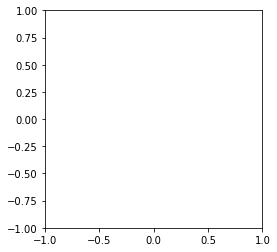

In [43]:
def test_visualize():
    particles = [Particle(0.3, 0.5, 1),
                 Particle(0.0, -0.5, -1),
                 Particle(-0.1, -0.4, 3)]
    
    simulator = ParticleSimulator(particles)
    visualize(simulator)

if __name__ == '__main__':
    test_visualize()

In [47]:
# Writing better tests and benchmarks with pytest-benchmark:

def test_evolve():
    particles = [Particle(0.3, 0.5, +1),
                 Particle(0.0, -0.5, -1),
                 Particle(-0.1, -0.4, +3)]
    
    simulator = ParticleSimulator(particles)

    simulator.evolve(0.1)
    p0, p1, p2 = particles

    def fequal(a, b, eps=1e-5):
        return abs(a - b) < eps 

    assert fequal(p0.x, 0.210269)
    assert fequal(p0.y, 0.543863)

    assert fequal(p1.x, -0.099334)
    assert fequal(p1.y, -0.490034)

    assert fequal(p2.x, 0.191358)
    assert fequal(p2.y, -0.365227)


In [53]:
import cProfile

pr =  cProfile.Profile()

pr.enable()

benchmark()

pr.disable()

pr.print_stats()

         751 function calls in 0.894 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.894    0.894 1559122893.py:7(<module>)
        1    0.000    0.000    0.000    0.000 1559122893.py:9(<module>)
      100    0.000    0.000    0.000    0.000 2930338771.py:10(__init__)
        1    0.000    0.000    0.894    0.894 2930338771.py:117(benchmark)
        1    0.000    0.000    0.000    0.000 2930338771.py:118(<listcomp>)
        1    0.000    0.000    0.000    0.000 2930338771.py:18(__init__)
        1    0.894    0.894    0.894    0.894 2930338771.py:21(evolve)
        2    0.000    0.000    0.000    0.000 codeop.py:140(__call__)
        4    0.000    0.000    0.000    0.000 compilerop.py:166(extra_flags)
        2    0.000    0.000    0.000    0.000 contextlib.py:107(__enter__)
        2    0.000    0.000    0.000    0.000 contextlib.py:116(__exit__)
        2    0.000    0.000    0.000    0.00

In [55]:
''' 
Optimizing our code 
Now that we have identified where exactly our app is spending most its time, make some changes and assess the change is performance.

To express the equations of motion in terms of radius, r, and angle , alpha. (instead of x and y)
then calculate the points on a circle using the following equation
'''
r = 11

alpha = 7 
from math import cos, sin

x = r * cos(alpha)

y = r * sin(alpha)



In [57]:
def evolve_fast(self, dt):
    timestep = 0.00001
    nsteps = int(dt/timestep)

    # Loop order is changed
    for p in self.particles:
        t_x_ang = timestep * p.ang_vel
        for i in range(nsteps):
            norm = (p.x**2 + p.y**2)**0.5
            p.x, p.y = (p.x - t_x_ang * p.y/norm,
                        p.y + t_x_ang * p.x/norm)


In [ ]:
evolve_fast(self, dt) 

In [59]:
# The dis module: to inspect how the code is converted to bytecode, we can use the dis module

import dis

# will print for each line in the function, a list of bytecode instructions.

dis.dis(ParticleSimulator.evolve)

 22           0 LOAD_CONST               1 (1e-05)
              2 STORE_FAST               2 (timestep)

 23           4 LOAD_GLOBAL              0 (int)
              6 LOAD_FAST                1 (dt)
              8 LOAD_FAST                2 (timestep)
             10 BINARY_TRUE_DIVIDE
             12 CALL_FUNCTION            1
             14 STORE_FAST               3 (nsteps)

 25          16 SETUP_LOOP             134 (to 152)
             18 LOAD_GLOBAL              1 (range)
             20 LOAD_FAST                3 (nsteps)
             22 CALL_FUNCTION            1
             24 GET_ITER
        >>   26 FOR_ITER               122 (to 150)
             28 STORE_FAST               4 (i)

 26          30 SETUP_LOOP             116 (to 148)
             32 LOAD_FAST                0 (self)
             34 LOAD_ATTR                2 (particles)
             36 GET_ITER
        >>   38 FOR_ITER               106 (to 146)
             40 STORE_FAST               5 (p)

 28    

In [67]:
# Pure Python Optimizations 
 
n = list(range(15))
display(n)

for i, _ in enumerate(n):
    n[i] += 1

display(n)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [64]:
# bisect module allows fast searches on sorted arrays. 

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [48]:
from matplotlib import pyplot as plt
from matplotlib import animation
from random import uniform
import timeit

class Particle:

    __slots__ = ('x', 'y', 'ang_speed')

    def __init__(self, x, y, ang_speed):
        self.x = x
        self.y = y
        self.ang_speed = ang_speed


class ParticleSimulator:

    def __init__(self, particles):
        self.particles = particles

    def evolve(self, dt):
        timestep = 0.00001
        nsteps = int(dt/timestep)

        for i in range(nsteps):
            for p in self.particles:

                norm = (p.x**2 + p.y**2)**0.5
                v_x = (-p.y)/norm
                v_y = p.x/norm

                d_x = timestep * p.ang_speed * v_x
                d_y = timestep * p.ang_speed * v_y

                p.x += d_x
                p.y += d_y

    # def evolve(self, dt):
    #     timestep = 0.00001
    #     nsteps = int(dt/timestep)

    #     # First, change the loop order
    #     for p in self.particles:
    #         t_x_ang = timestep * p.ang_speed
    #         for i in range(nsteps):
    #             norm = (p.x**2 + p.y**2)**0.5
    #             p.x, p.y = p.x - t_x_ang*p.y/norm, p.y + t_x_ang * p.x/norm

def visualize(simulator):

    X = [p.x for p in simulator.particles]
    Y = [p.y for p in simulator.particles]

    fig = plt.figure()
    ax = plt.subplot(111, aspect='equal')
    line, = ax.plot(X, Y, 'ro')

    # Axis limits
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)

    # It will be run when the animation starts
    def init():
        line.set_data([], [])
        return line,

    def animate(i):
        # We let the particle evolve for 0.1 time units
        simulator.evolve(0.01)
        X = [p.x for p in simulator.particles]
        Y = [p.y for p in simulator.particles]

        line.set_data(X, Y)
        return line,

    # Call the animate function each 10 ms
    anim = animation.FuncAnimation(fig,
                                   animate,
                                   init_func=init,
                                   blit=True,
                                   interval=10)
    plt.show()


def test_visualize():
    particles = [Particle( 0.3, 0.5, +1),
                 Particle( 0.0, -0.5, -1),
                 Particle(-0.1, -0.4, +3)]

    simulator = ParticleSimulator(particles)
    visualize(simulator)

def test_evolve():
    particles = [Particle( 0.3,  0.5, +1),
                 Particle( 0.0, -0.5, -1),
                 Particle(-0.1, -0.4, +3)]

    simulator = ParticleSimulator(particles)

    simulator.evolve(0.1)

    p0, p1, p2 = particles

    def fequal(a, b):
        return abs(a - b) < 1e-5

    assert fequal(p0.x, 0.2102698450356825)
    assert fequal(p0.y, 0.5438635787296997)

    assert fequal(p1.x, -0.0993347660567358)
    assert fequal(p1.y, -0.4900342888538049)

    assert fequal(p2.x,  0.1913585038252641)
    assert fequal(p2.y, -0.3652272210744360)


def benchmark():
    particles = [Particle(uniform(-1.0, 1.0),
                          uniform(-1.0, 1.0),
                          uniform(-1.0, 1.0))
                  for i in range(100)]

    simulator = ParticleSimulator(particles)
    simulator.evolve(0.1)


def timing():
    result = timeit.timeit('benchmark()',
                           setup='from __main__ import benchmark',
                           number=10)
    # Result is the time it takes to run the whole loop
    print(result)

    result = timeit.repeat('benchmark()',
                           setup='from __main__ import benchmark',
                           number=10,
                           repeat=3)
    # Result is a list of times
    print(result)


def benchmark_memory():
    particles = [Particle(uniform(-1.0, 1.0),
                          uniform(-1.0, 1.0),
                          uniform(-1.0, 1.0))
                  for i in range(100000)]

    simulator = ParticleSimulator(particles)
    simulator.evolve(0.001)


if __name__ == '__main__':
    benchmark()


In [49]:
benchmark()

In [50]:

def test_evolve(benchmark):
    particles = [Particle( 0.3,  0.5, +1),
                 Particle( 0.0, -0.5, -1),
                 Particle(-0.1, -0.4, +3)]

    simulator = ParticleSimulator(particles)

    simulator.evolve(0.1)

    p0, p1, p2 = particles

    def fequal(a, b):
        return abs(a - b) < 1e-5

    assert fequal(p0.x, 0.2102698450356825)
    assert fequal(p0.y, 0.5438635787296997)

    assert fequal(p1.x, -0.0993347660567358)
    assert fequal(p1.y, -0.4900342888538049)

    assert fequal(p2.x,  0.1913585038252641)
    assert fequal(p2.y, -0.3652272210744360)

    benchmark(simulator.evolve, 0.1)


In [52]:

test_evolve(benchmark)

TypeError: benchmark() takes 0 positional arguments but 2 were given